Step 1: Load and Initial Exploration
python


In [1]:
# Cell 1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_excel('sleep_dataset.xlsx')


Step 2: Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Species       87 non-null     object 
 1   Genus         87 non-null     object 
 2   Order         87 non-null     object 
 3   Family        87 non-null     object 
 4   Vore          87 non-null     object 
 5   Conservation  87 non-null     object 
 6   BodyWt        87 non-null     float64
 7   BrainWt       87 non-null     float64
 8   TotalSleep    87 non-null     float64
 9   Awake         87 non-null     float64
 10  NonDreaming   47 non-null     float64
 11  Dreaming      63 non-null     float64
 12  LifeSpan      87 non-null     float64
 13  Gestation     87 non-null     float64
 14  Predation     58 non-null     float64
 15  Exposure      58 non-null     float64
 16  Danger        58 non-null     float64
dtypes: float64(11), object(6)
memory usage: 11.7+ KB
None


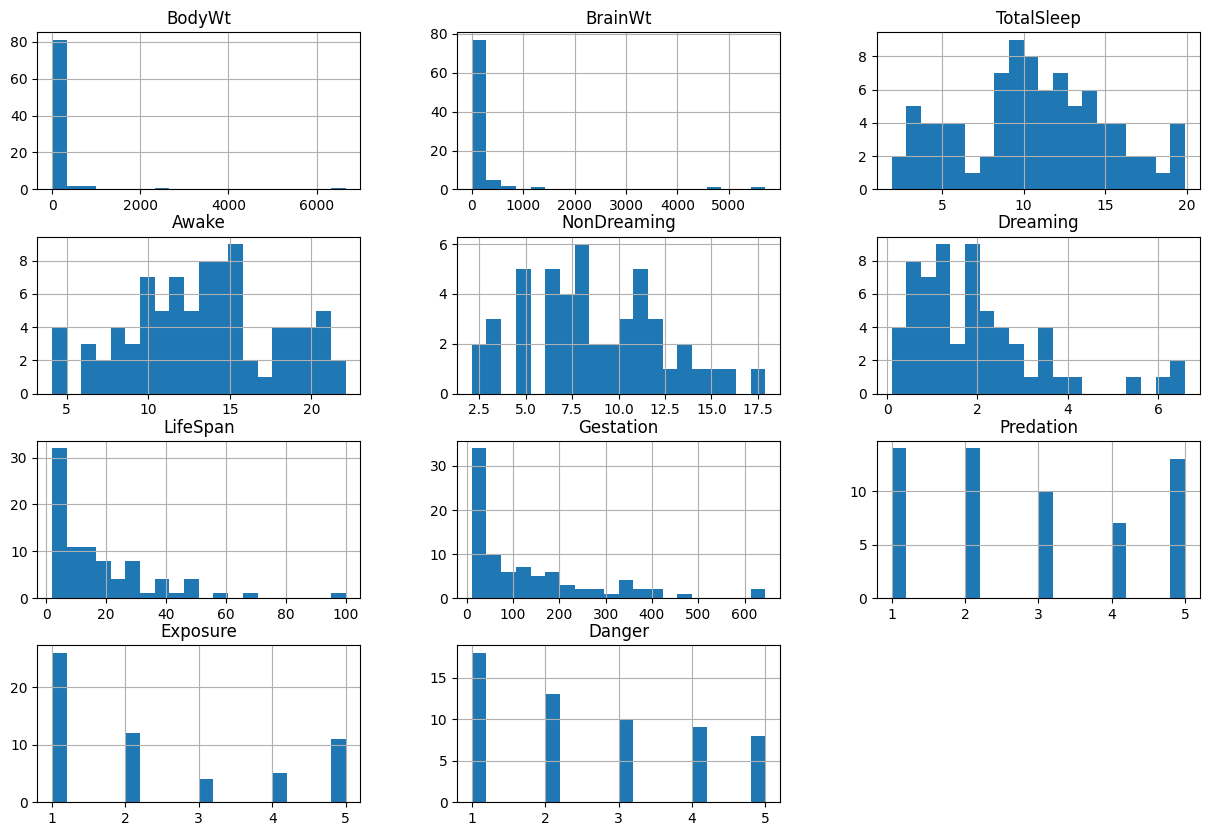

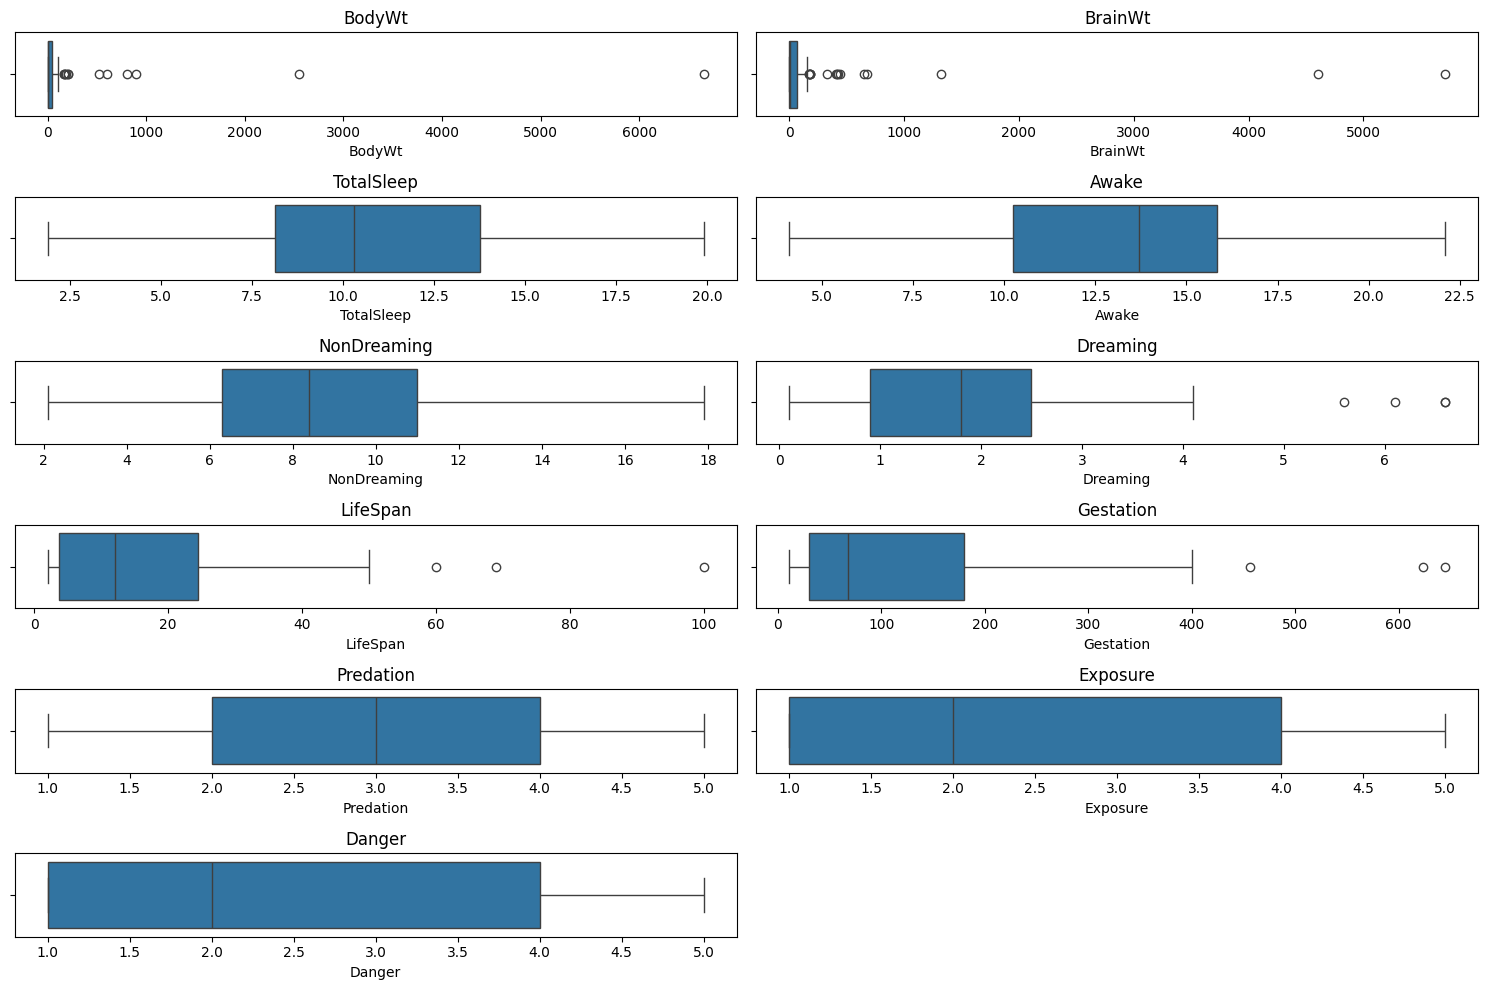

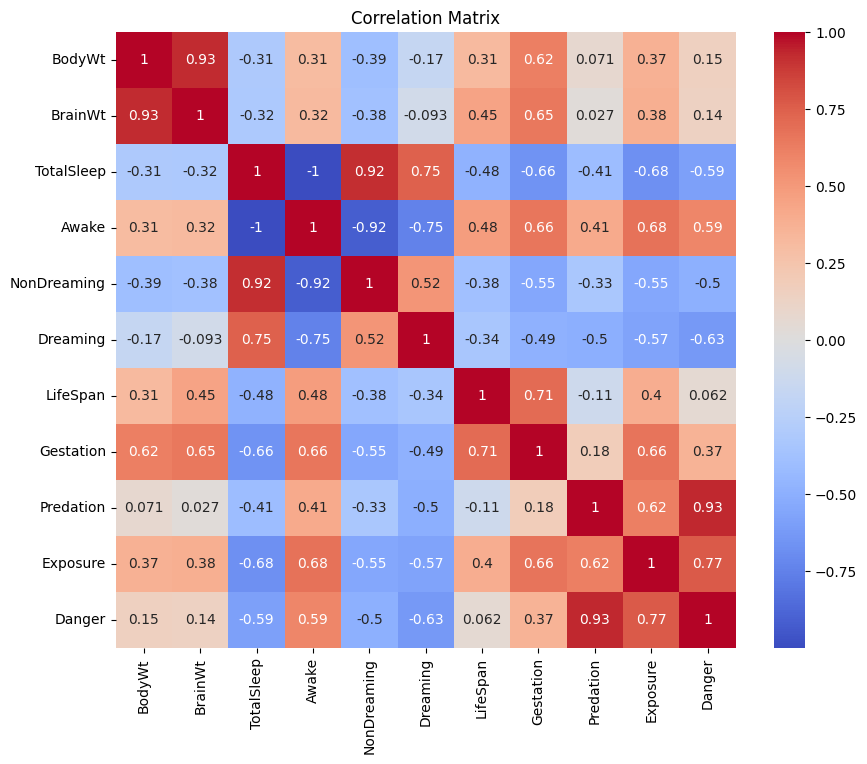

In [2]:
# Cell 2
# Check basic info
print(df.info())

# Histograms for numerical attributes
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols].hist(bins=20, figsize=(15, 10))
plt.show()

# Boxplots for numerical columns to identify outliers
plt.figure(figsize=(15, 10))

# Define the number of rows and columns for subplots
num_cols = len(numerical_cols)
num_rows = (num_cols + 1) // 2  # Round up if odd number of columns

# Create subplots
for i, column in enumerate(numerical_cols):
    plt.subplot(num_rows, 2, i+1)
    sns.boxplot(data=df, x=column)
    plt.title(column)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Correlation matrix for numerical columns
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Step 3: Handling Missing Values without Deleting Rows or Columns

In [3]:
# Cell 3
imputer = SimpleImputer(strategy='median')
df[['NonDreaming']] = imputer.fit_transform(df[['NonDreaming']])

Step 4: Feature Engineering and Handling Outliers

In [4]:
#Cell 4
# Create the 'BrainBodyRatio' before splitting the dataset
df['BrainBodyRatio'] = df['BrainWt'] / df['BodyWt']

In [5]:
from scipy.stats.mstats import winsorize
# Apply winsorizing to numerical columns identified to have outliers
for column in numerical_cols:
    df[column] = winsorize(df[column], limits=[0.03, 0.03])


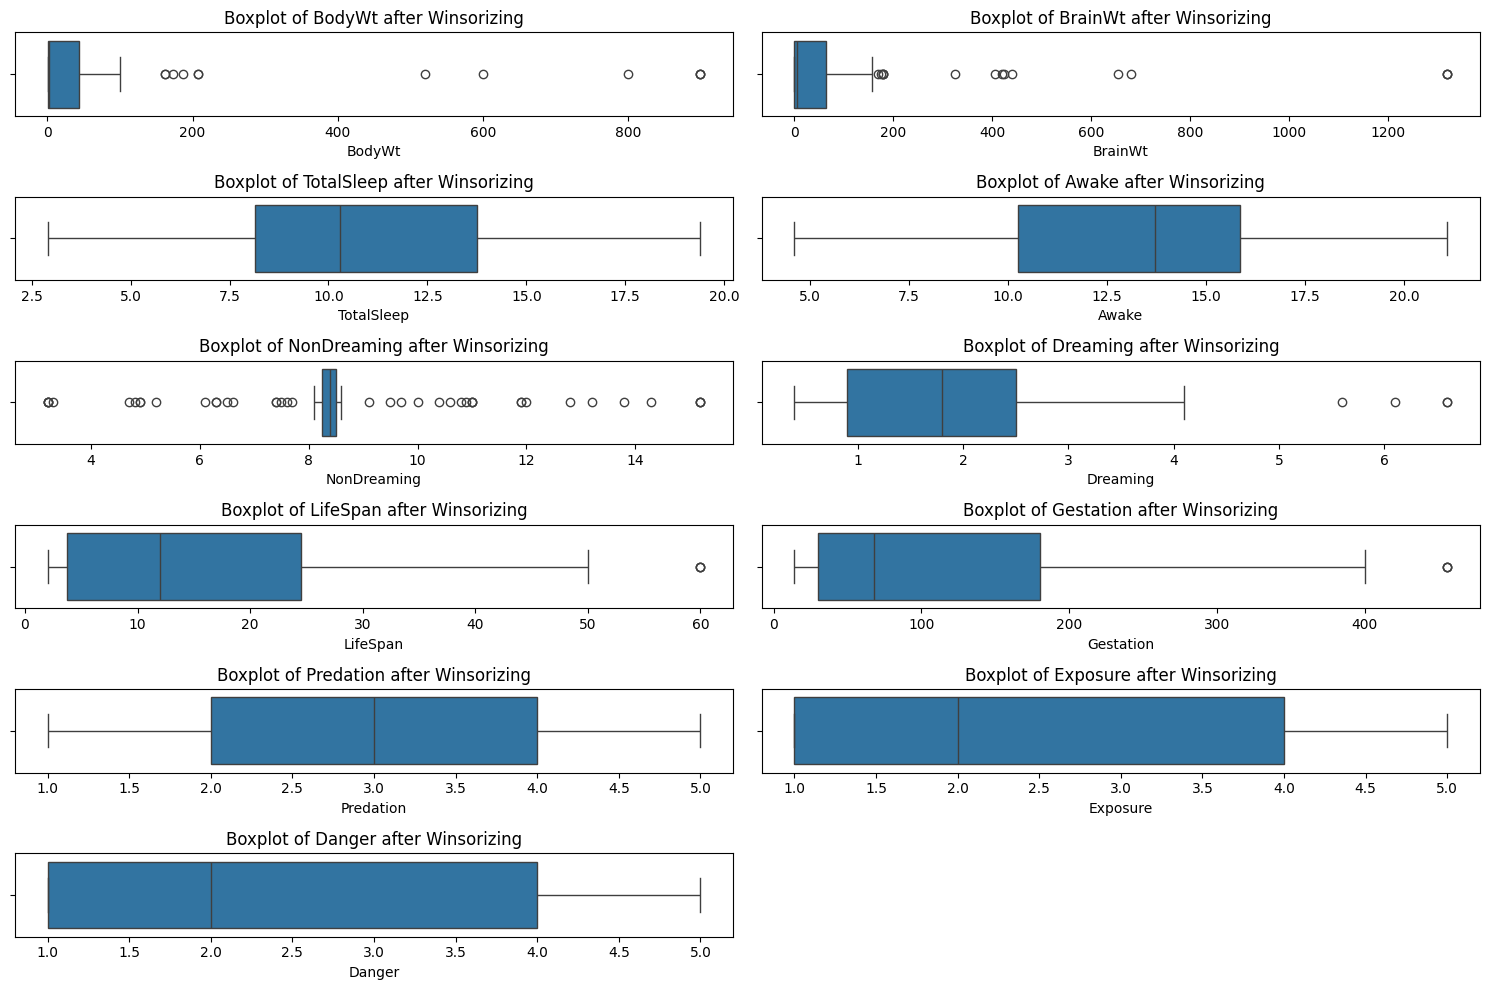

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize numerical columns after winsorizing
plt.figure(figsize=(15, 10))

# Define the number of rows and columns for subplots
num_cols = len(numerical_cols)
num_rows = (num_cols + 1) // 2  # Round up if odd number of columns

# Create subplots
for i, column in enumerate(numerical_cols):
    plt.subplot(num_rows, 2, i+1)
    sns.boxplot(data=df, x=column)
    plt.title(f'Boxplot of {column} after Winsorizing')

# Adjust layout and display
plt.tight_layout()
plt.show()


In [7]:
# Cell 5
# Now, split the dataset
X = df.drop(['TotalSleep', 'Dreaming'], axis=1)
y = df[['TotalSleep', 'Dreaming']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 5: Preprocessing Pipeline for Feature Encoding and Scaling

In [8]:
# Cell 6
# Define numerical and categorical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.drop(['TotalSleep', 'Dreaming'])
categorical_features = df.select_dtypes(include=['object']).columns

# Create transformers
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Step 6: Model Training and Evaluation

Linear Regression Model

In [9]:
# Cell 7: Preparing Data, Defining Models, and Model Training

# Filter rows where 'TotalSleep' or 'Dreaming' is NaN in the training and testing sets
train_filter = y_train['Dreaming'].notna() & y_train['TotalSleep'].notna()
X_train_filtered = X_train.loc[train_filter]
y_train_filtered = y_train.loc[train_filter]

test_filter = y_test['Dreaming'].notna() & y_test['TotalSleep'].notna()
X_test_filtered = X_test.loc[test_filter]
y_test_filtered = y_test.loc[test_filter]

# Define models with preprocessing pipeline included
from sklearn.pipeline import make_pipeline

model_sleep = make_pipeline(preprocessor, LinearRegression())
model_dreaming = make_pipeline(preprocessor, LinearRegression())

# Train and evaluate model for TotalSleep
model_sleep.fit(X_train_filtered, y_train_filtered['TotalSleep'])
sleep_predictions = model_sleep.predict(X_test_filtered)
print(f"TotalSleep Model MSE: {mean_squared_error(y_test_filtered['TotalSleep'], sleep_predictions)}")

# Train and evaluate model for Dreaming
model_dreaming.fit(X_train_filtered, y_train_filtered['Dreaming'])
dreaming_predictions = model_dreaming.predict(X_test_filtered)
print(f"Dreaming Model MSE: {mean_squared_error(y_test_filtered['Dreaming'], dreaming_predictions)}")


TotalSleep Model MSE: 0.6685859929536085
Dreaming Model MSE: 0.253761230960426


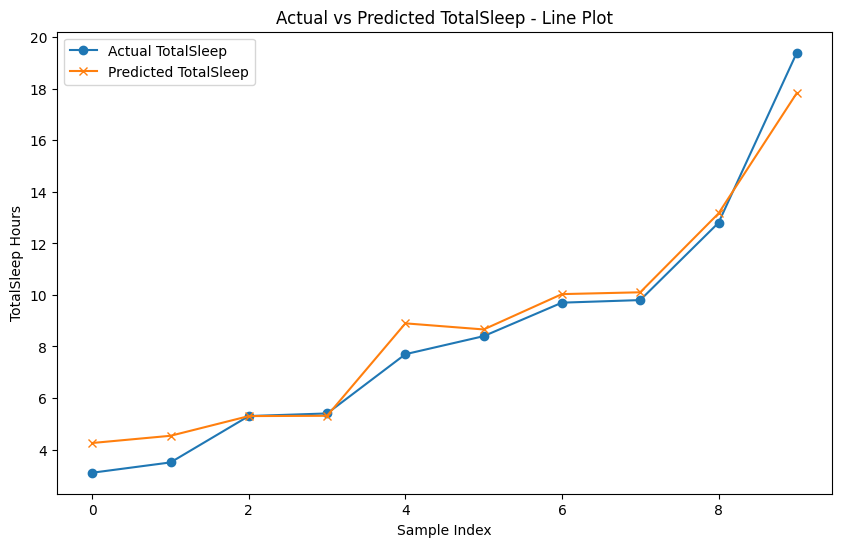

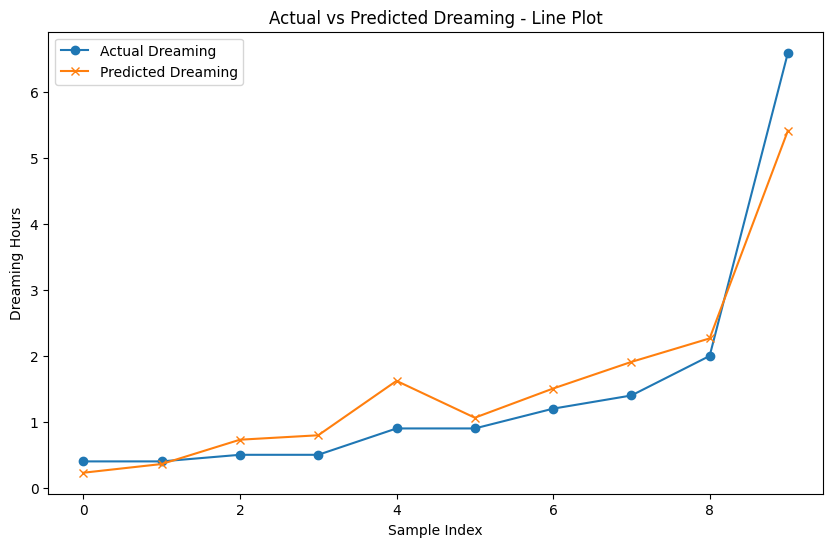

In [10]:
# Prepare the data for plotting - sort by actual values for TotalSleep
total_sleep_sorted = y_test_filtered.sort_values(by='TotalSleep')
total_sleep_pred = model_sleep.predict(X_test_filtered.loc[total_sleep_sorted.index])

# Plotting Actual vs Predicted for TotalSleep with line plot
plt.figure(figsize=(10, 6))
plt.plot(total_sleep_sorted['TotalSleep'].values, label='Actual TotalSleep', marker='o')
plt.plot(total_sleep_pred, label='Predicted TotalSleep', marker='x')
plt.title('Actual vs Predicted TotalSleep - Line Plot')
plt.xlabel('Sample Index')
plt.ylabel('TotalSleep Hours')
plt.legend()
plt.show()

# Prepare the data for plotting - sort by actual values for Dreaming
dreaming_sorted = y_test_filtered.sort_values(by='Dreaming')
dreaming_pred = model_dreaming.predict(X_test_filtered.loc[dreaming_sorted.index])

# Plotting Actual vs Predicted for Dreaming with line plot
plt.figure(figsize=(10, 6))
plt.plot(dreaming_sorted['Dreaming'].values, label='Actual Dreaming', marker='o')
plt.plot(dreaming_pred, label='Predicted Dreaming', marker='x')
plt.title('Actual vs Predicted Dreaming - Line Plot')
plt.xlabel('Sample Index')
plt.ylabel('Dreaming Hours')
plt.legend()
plt.show()


xgboost Model

c:\Users\Abdul Rehman\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Abdul Rehman\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBoost TotalSleep Model MSE: 0.13377282003465907
XGBoost Dreaming Model MSE: 0.4003080939186467


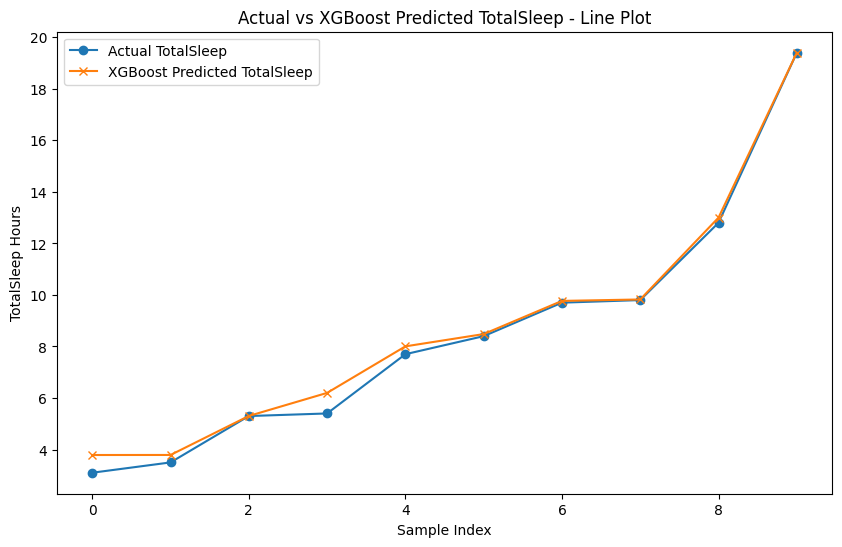

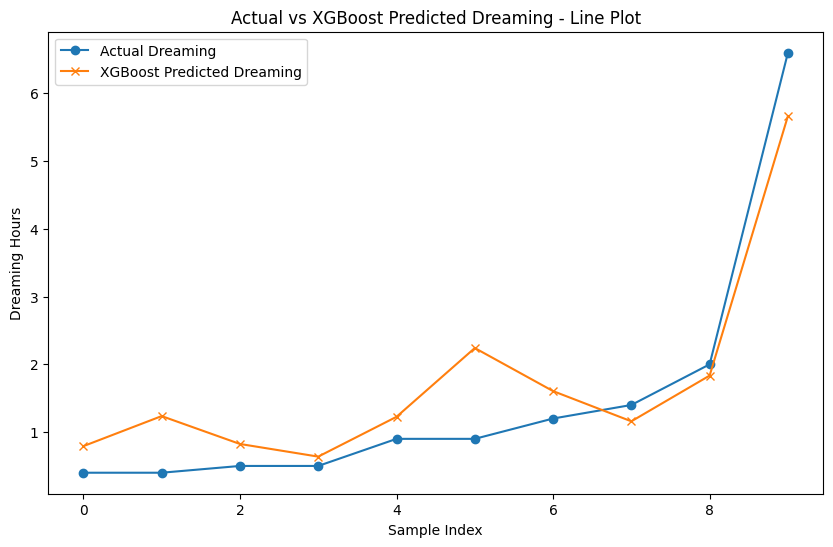

In [11]:
from xgboost import XGBRegressor

# Define XGBoost model
model_xgboost_sleep = make_pipeline(preprocessor, XGBRegressor())

# Train XGBoost model for TotalSleep
model_xgboost_sleep.fit(X_train_filtered, y_train_filtered['TotalSleep'])
xgboost_sleep_predictions = model_xgboost_sleep.predict(X_test_filtered)
print(f"XGBoost TotalSleep Model MSE: {mean_squared_error(y_test_filtered['TotalSleep'], xgboost_sleep_predictions)}")

# Train XGBoost model for Dreaming
model_xgboost_dreaming = make_pipeline(preprocessor, XGBRegressor())
model_xgboost_dreaming.fit(X_train_filtered, y_train_filtered['Dreaming'])
xgboost_dreaming_predictions = model_xgboost_dreaming.predict(X_test_filtered)
print(f"XGBoost Dreaming Model MSE: {mean_squared_error(y_test_filtered['Dreaming'], xgboost_dreaming_predictions)}")

# Prepare the data for plotting - sort by actual values for TotalSleep
xgboost_total_sleep_sorted = y_test_filtered.sort_values(by='TotalSleep')
xgboost_total_sleep_pred = model_xgboost_sleep.predict(X_test_filtered.loc[xgboost_total_sleep_sorted.index])

# Plotting Actual vs Predicted for TotalSleep with line plot
plt.figure(figsize=(10, 6))
plt.plot(xgboost_total_sleep_sorted['TotalSleep'].values, label='Actual TotalSleep', marker='o')
plt.plot(xgboost_total_sleep_pred, label='XGBoost Predicted TotalSleep', marker='x')
plt.title('Actual vs XGBoost Predicted TotalSleep - Line Plot')
plt.xlabel('Sample Index')
plt.ylabel('TotalSleep Hours')
plt.legend()
plt.show()

# Prepare the data for plotting - sort by actual values for Dreaming
xgboost_dreaming_sorted = y_test_filtered.sort_values(by='Dreaming')
xgboost_dreaming_pred = model_xgboost_dreaming.predict(X_test_filtered.loc[xgboost_dreaming_sorted.index])

# Plotting Actual vs Predicted for Dreaming with line plot
plt.figure(figsize=(10, 6))
plt.plot(xgboost_dreaming_sorted['Dreaming'].values, label='Actual Dreaming', marker='o')
plt.plot(xgboost_dreaming_pred, label='XGBoost Predicted Dreaming', marker='x')
plt.title('Actual vs XGBoost Predicted Dreaming - Line Plot')
plt.xlabel('Sample Index')
plt.ylabel('Dreaming Hours')
plt.legend()
plt.show()
